<a href="https://colab.research.google.com/github/vlunic00/Artist_Recognition/blob/main/Artist_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (BatchNormalization,
                                     Dense,
                                     Dropout,
                                     Flatten,
                                     Input,
                                     RandomFlip,
                                     RandomRotation,
                                     RandomTranslation,
                                     RandomZoom)
from tensorflow.keras.models import Model, Sequential

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

tf.__version__

Saving artists.csv to artists.csv


'2.12.0'

In [3]:
sns.set_style('whitegrid')

In [4]:
# preparing the artist data
# won't be using artists with less than 100 paintings in the dataset -- to few too be accurate

min_num_paintings = 100

#best to use a pretrained model due to a lack of data
base_model_trainable = False

In [5]:
import io

df = pd.read_csv(io.BytesIO(uploaded['artists.csv']))

In [6]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [7]:
# bio and wikipedia are irrelevant for this model (might expand model later to show more info)

df = df.drop(['bio', 'wikipedia'], axis=1)

# remove artists with not enough paintings

df = df.loc[df['paintings'] >= min_num_paintings]
df = df.reset_index(drop=True)

In [8]:
# the dataset is imbalanced (some artists have a lot more paintings in it)
# therefore we need to alter the weights to somewhat lessen the impact on the model

df['class_weight'] = df['paintings'].sum() / (df.shape[0] * df['paintings'])

In [9]:
# we will need the class_weights for training

class_weights = df['class_weight'].to_dict()

# name_mapping will be used to translate the predicted integer to the artist name
name_mapping = df['name'].to_dict()

#name_mapping_reverse will be used to add the correct labels to the resized images

name_mapping_reverse = {y: x for x, y in name_mapping.items()}

# n_classes will be used for model construction

n_classes = len(class_weights)

In [10]:
img_dir = 'drive/MyDrive/resized'

# the model works with 256x256 images

img_height = 256
img_width = 256

files = os.listdir(img_dir)

# img_list contains the images
# label list contains the artist names

img_list = []
label_list = []

# in the loop we go through each image, checking if the artist name is in our dataframe
# and putting it in the label_list. We then add the corresponding image to the img_list
# so that the indices are the same for the corresponding artist and painting

for file in files:
    idx = file.rfind('_')
    name = file[:idx].replace('_', ' ')
    if name in name_mapping_reverse.keys():
        label_list.append(name_mapping_reverse[name])
        img = cv2.imread(os.path.join(img_dir, file))
        img = cv2.resize(img, (img_height, img_width))
        img_list.append(img)

images = np.asarray(img_list)
labels = np.asarray(label_list)

In [11]:
# due to the small amount of data, I opted for a 80-10-10 split

X, X_test, y, y_test = train_test_split(images,
                                        labels,
                                        test_size = 0.1,
                                        random_state = 13)

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size = 1/9,
                                                  random_state = 13)

In [13]:
# we will be using the VGG19 model
base_model = VGG19(include_top=False,
                    classes = n_classes,
                    input_shape = (img_height, img_width, 3))

base_model.trainable = base_model_trainable
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [14]:
# since we aren't working with too much data, some data augmentation should be useful

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])

In [15]:
# here we create the last part of our model, one that's meant to classify the paintings

prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])

In [16]:
# the final model looks like this:
# we add the data_augmentation layer to the front
# then the imported preprocess_input layer
# and at the end of the base_model we add our custom predictions layer

inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
outputs = prediction(x)

model = Model(inputs, outputs)

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 sequential_1 (Sequential)   (None, 30)                17057822  
                                                             

In [18]:
epochs = 100

# we'll use smaller batch sizes in an attempt to avoid overfitting

batch_size = 16

early_stopping = EarlyStopping(patience=20,
                               verbose = 2,
                               restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    class_weight = class_weights,
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = early_stopping)



Epoch 1/100
335/335 [==============================] - 61s 137ms/step - loss: 3.4023 - accuracy: 0.3048 - val_loss: 3.1677 - val_accuracy: 0.3737
Epoch 2/100
335/335 [==============================] - 40s 119ms/step - loss: 2.2001 - accuracy: 0.4160 - val_loss: 2.4499 - val_accuracy: 0.4589
Epoch 3/100
335/335 [==============================] - 40s 120ms/step - loss: 1.8851 - accuracy: 0.4687 - val_loss: 2.1515 - val_accuracy: 0.4783
Epoch 4/100
335/335 [==============================] - 39s 118ms/step - loss: 1.6436 - accuracy: 0.4947 - val_loss: 2.1613 - val_accuracy: 0.5007
Epoch 5/100
335/335 [==============================] - 41s 122ms/step - loss: 1.5500 - accuracy: 0.5279 - val_loss: 2.1844 - val_accuracy: 0.4948
Epoch 6/100
335/335 [==============================] - 41s 122ms/step - loss: 1.4571 - accuracy: 0.5339 - val_loss: 2.0966 - val_accuracy: 0.4903
Epoch 7/100
335/335 [==============================] - 41s 122ms/step - loss: 1.3988 - accuracy: 0.5519 - val_loss: 2.3648 -

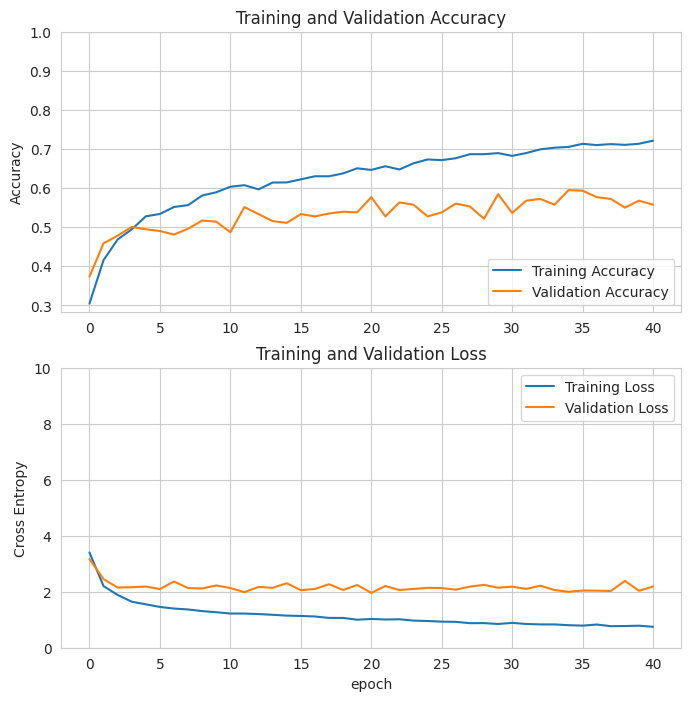

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()